##### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from PIL import Image
import librosa
import librosa.display
import os
import json
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "./LMT_108_SurfaceMaterials_Database/AccelScansComponents/Movement/Training/G1EpoxyRasterPlate_Movement_X_train1.txt"

In [3]:
acc_x_move_data = pd.read_csv(path, names = ["Acceleration_X_Move"]).to_numpy().ravel()

In [4]:
acc_x_move_data

array([-1.7387028e-01, -1.6932462e-01, -1.5406417e-01, ...,
       -2.7584957e-03,  1.6371729e-04,  1.7871689e-03])

In [5]:
x = np.abs(librosa.stft(acc_x_move_data))
x.shape

(1025, 94)

In [6]:
y = librosa.amplitude_to_db(x)
y.shape

(1025, 94)

In [7]:
z = librosa.db_to_amplitude(y)
q = librosa.griffinlim(z)
q

array([-0.09805384, -0.09703759, -0.09557103, ...,  0.02114447,
        0.02116831,  0.02573928])

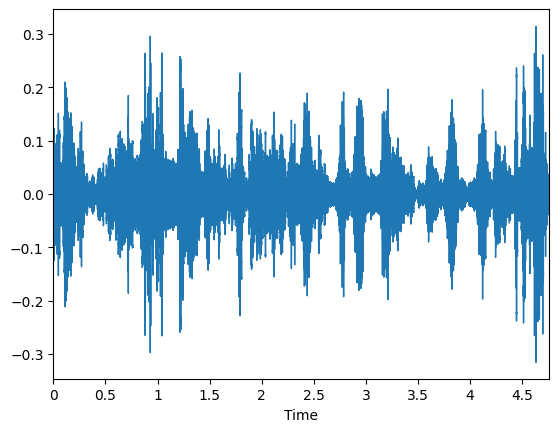

In [8]:
librosa.display.waveplot(q, sr=10000)

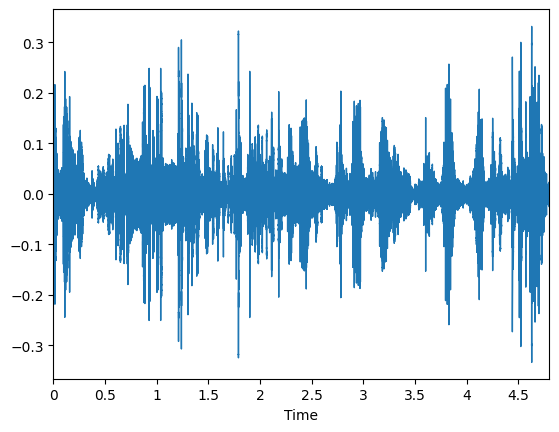

In [9]:
librosa.display.waveplot(acc_x_move_data, sr=10000)

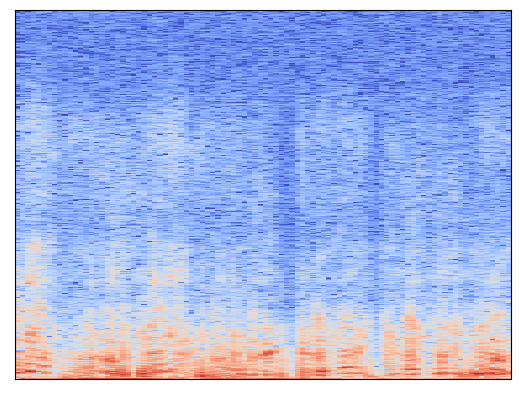

In [10]:
librosa.display.specshow(y, sr=10000)

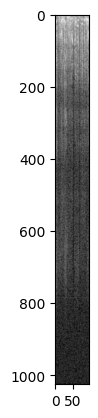

In [11]:
plt.imshow(y, cmap='gray')

##### Creating Dataloader

In [12]:
acc_path = "./LMT_108_SurfaceMaterials_Database/AccelScansComponents/Movement"
img_path = "./LMT_108_SurfaceMaterials_Database/ImageScans/Flash" 

In [13]:
class CustomDataset(Dataset):
    def __init__(self, acc_path, img_path, transform_spec=None, transform_img = None, train = True):
        self.acc_path = acc_path
        self.img_path = img_path
        self.transform_spec = transform_spec
        self.transform_img = transform_img
        self.train = train
        self.acc_data = []
        self.img_data = []
        self.mapping = {'2':'10', '1':'1', '3':'2', '4':'3', '5':'4', '6':'5', '7':'6', '8':'7', '9':'8', '0':'9'}
        self.load_data()
      
    def load_data(self):
        if self.train:
            self.acc_path = os.path.join(self.acc_path, "Training")
            self.img_path = os.path.join(self.img_path, "Training")
                
        else:
            self.acc_path = os.path.join(self.acc_path, "Testing")
            self.img_path = os.path.join(self.img_path, "Testing")
        
        for file in os.listdir(self.img_path):
            if self.train:
                for i in range(5):
                    self.img_data.append(file)
            else:
                self.img_data.append(file)

            train_no = file[-5]
            acc_file = file[6:]
            acc_file = acc_file.replace('_Image_', '_Movement_')
            acc_file = acc_file.replace(f'_{self.mapping[train_no]}_', '_Z_')
            acc_file = acc_file[:-5] + self.mapping[train_no] + '.txt'
            if self.train:
                for i in range(5):
                    self.acc_data.append(acc_file)
            else:
                self.acc_data.append(acc_file)

    def __len__(self):
        return len(self.acc_data)

    def __getitem__(self, idx):
        acc_file = os.path.join(self.acc_path, self.acc_data[idx])
        img_file = os.path.join(self.img_path, self.img_data[idx])
        
        acc_data = pd.read_csv(acc_file).to_numpy().ravel()
        spec = np.abs(librosa.stft(acc_data))
        spec = librosa.amplitude_to_db(spec)
        
        if self.transform_spec is not None:
            spec = self.transform_spec(spec)
        
        img = Image.open(img_file)
        if self.transform_img is not None:
            img = self.transform_img(img)
            
        return img, spec

In [14]:
transform_spec = transforms.Compose([
    transforms.ToTensor()
])

transform_img_train = transforms.Compose([
        transforms.Resize((480,320)),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_img_test = transforms.Compose([
        transforms.Resize((480,320)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = CustomDataset(acc_path, img_path, transform_spec = transform_spec, transform_img = transform_img_train, train = True)
test_ds = CustomDataset(acc_path, img_path, transform_spec = transform_spec, transform_img = transform_img_test, train = False)

In [15]:
print(len(train_ds), len(test_ds))

5400 1080


In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [17]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 480, 320]) torch.Size([32, 1, 1025, 94])


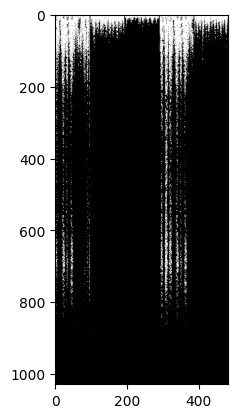

In [18]:
dataiter = iter(train_loader)
data = next(dataiter)

imgs, specs = data[0], data[1]
print(imgs.shape, specs.shape)
imshow(torchvision.utils.make_grid(specs[:5]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


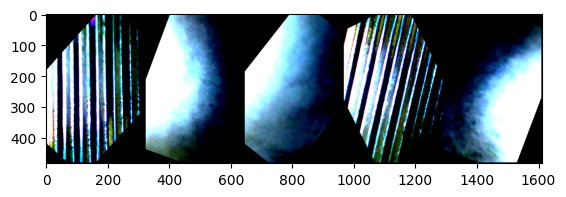

In [19]:
imshow(torchvision.utils.make_grid(imgs[:5]))

# Model

In [20]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
import random
config = dict(
    saved_path="saved/random.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)


random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        # Define the generator network
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        
        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(1024)
        self.bn6 = nn.BatchNorm2d(1024)
        self.bn7 = nn.BatchNorm2d(1024)
        self.bn8 = nn.BatchNorm2d(1024)
        self.bn9 = nn.BatchNorm2d(512)
        self.bn10 = nn.BatchNorm2d(256)
        self.bn11 = nn.BatchNorm2d(128)
        self.bn12 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        
        # Decoder
        x = F.relu(self.bn9(self.deconv1(x)))
        x = F.relu(self.bn10(self.deconv2(x)))
        x = F.relu(self.bn11(self.deconv3(x)))
        x = F.relu(self.bn12(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x))
        x = F.interpolate(x, size=(1025, 94), mode='bicubic', align_corners=True)
        return x
    
model = Generator()

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params1 = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total number of trainable parameters',pytorch_total_params, pytorch_total_params1)

Total number of trainable parameters 50615937 50615937


In [24]:
def train_model(model,criterion,optimizer, train_dl, valid_dl,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    best_acc = 0.3
    for epoch in range(num_epochs):
        running_loss = 0.0
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()
        for i,(x,y) in enumerate(train_dl):
            x = x.float()
            y = y.float()
            if config['channels_last']:
                x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
            else:
                x = x.to(config['device'])
            y = y.to(config['device']) #CHW --> #HWC
            optimizer.zero_grad()
            
            outputs = model(x) 
            
            #print(outputs.shape)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / i))
            
            if i == 100:
                break
        
        #print(f'Loss after {epoch+1}/{num_epochs}: {running_loss/i}')
            
        
        #validation
        model.eval()
        running_loss_valid = 0.0
        total = 0
        with torch.no_grad():
            for x,y in valid_dl:
                if config['channels_last']:
                    x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
                else:
                    x = x.to(config['device'])
                y = y.to(config['device'])
                outputs = model(x)
                valid_loss = criterion(outputs,y)
                running_loss_valid += valid_loss.item()
                total += 1
                if total == 100:
                    break

            
        epoch_loss = running_loss_valid / len(test_ds)
        
        print("Train Loss",running_loss/len(train_ds))
        print("Validation Loss is {}".format(epoch_loss))
        
#         if epoch_acc.cpu()>best_acc:
#             print('One of the best validation accuracy found.\n')
#             #torch.save(model.state_dict(), config['best_saved_path'])
#             best_acc = epoch_acc.cpu()
    
    #torch.save(model.state_dict(), config['saved_path'])


In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
model =  model.to(config['device'])
train_model(model,criterion,optimizer,train_loader, test_loader,num_epochs=10)

Epoch 0/9
----------
[1,    10] loss: 599.748
[1,    20] loss: 593.005
[1,    30] loss: 586.050
[1,    40] loss: 576.628
[1,    50] loss: 569.944
[1,    60] loss: 568.487


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.